This script explores the effect of temperature threshold exceedances on global GDP.

Key research questions we look at are 
 - What is a good model for relating GDP to metrics describing GMT? 
 - What is the marginial effect of cumulative exceedane depth & global GDP? 
 - What is the marginial effect of cumulative exceedane depth on country-level GDP? 

The goal of this script is to use the model found in 001_model_selection.ipynb to look at the marginal effect of cumulative exceedance depth on global & country-level GDP.  

In [1]:
import sys
sys.path.append('/Users/schoens/Documents/Projekte/Econ/Code/v3/')

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm

from pathlib import Path
import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

#### Loading & Preparing Data

In [3]:
# load parameter
thrshld        = 1.5
sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_eoc', 'gmt_eoc tas_baseline']
# load data 
regression_df  = pd.read_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'), index_col = 0)

# prepare data for regression analysis
#    - allowing for country fixed effects
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1
#     - creating predictor matrix (standardizing model output does not alter results --> omitted for interpretability)
X              = np.c_[regression_df[sel_predictors], X_intercept]
#     - creating target variable 
y              = regression_df['log_diff_SSP2'].values  

#### Fitting Regression Model

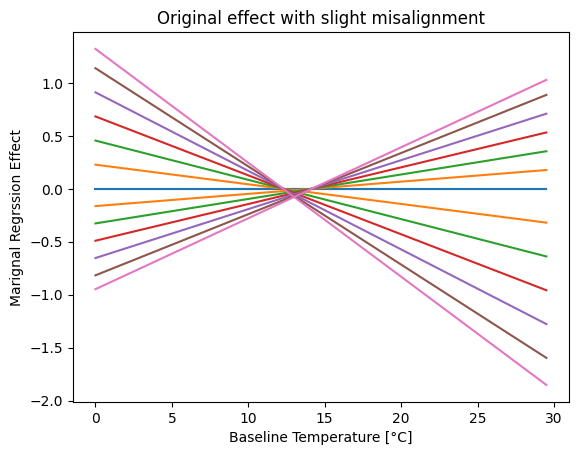

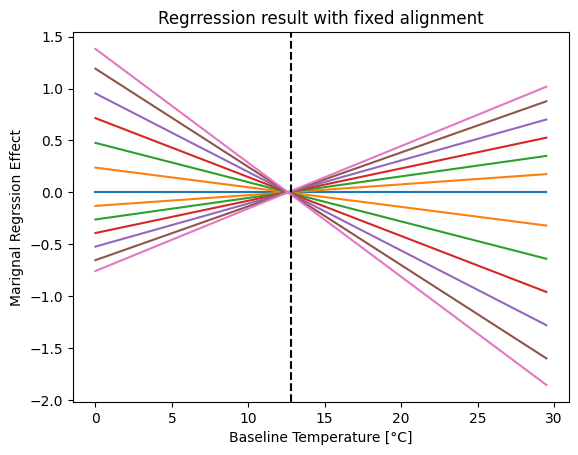

In [5]:
# effects from x_exc and x_uxc should have the same zero-crossing for keeping validaty 
# if the effects would not have the same zero-crossing, exceeding a temperature threshold could lead 
# to an increase(decrease) in GDP while remaining below a temperature threshold would have the same effect i .e. 
# also lead to a decrease(increase) in GDP, which is physically implausible; the results from the ordinary regression are already 
# well aligned, but just slightly off 
x_EXC = np.arange(0,145,1)
x_Ts  = np.arange(0,30,0.5) 

# - ordinary regression wihtout intriducing constraints: 
country_model  = sm.OLS(endog = y, exog = X).fit()
plt.figure()
i_color = 0
for x_E in [0,25,50,75,100,125,145]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color])
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
# plt.axvline(x = 12.7, color = 'black', linestyle = '--')
plt.title('Original effect with slight misalignment')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

# - introducing a constrained regression model: 
from scipy.optimize import curve_fit

def objective_function(x, *a):
    b2    = a[2]/a[0]*a[1]
    a_adj = np.append(a[:3], np.append([b2], a[3:]))
    return(a_adj@x)

popt, pcov = curve_fit(objective_function, 
                       X.T,
                       y,
                       p0 = np.append(country_model.params[:3], 
                                      country_model.params[4:]))

results_country_params = np.append(popt[:3], np.append([popt[2]/popt[0]*popt[1]], popt[3:]))
country_model.params   = results_country_params

x_EXC = np.arange(0,145,1)
x_Ts  = np.arange(0,30,0.5) 

plt.figure()
i_color = 0
for x_E in [0,25,50,75,100,125,145]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color])
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
plt.axvline(x = 12.8, color = 'black', linestyle = '--')
plt.title('Regrression result with fixed alignment')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

# fitting a global model (only approximates averages)
sel_global_predictors  = [predictor for predictor in sel_predictors if not 'tas_baseline' in predictor]
X_global               = np.c_[regression_df[sel_global_predictors], X_intercept]
y                      = regression_df['log_diff_SSP2'].values  
global_model           = sm.OLS(endog = y, exog = X_global).fit()

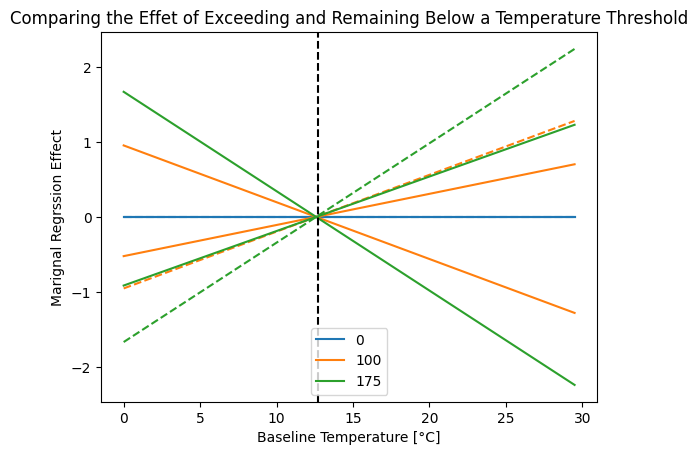

In [6]:
x_EXC = np.arange(0,175,1)
x_Ts  = np.arange(0,30,0.5) 

plt.figure()
i_color = 0
for x_E in [0,100,175]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color], label = x_E)
    plt.plot(x_Ts, -(country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E), color = sns.color_palette()[i_color], linestyle = '--')
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
plt.axvline(x = 12.7, color = 'black', linestyle = '--')
plt.title('Comparing the Effet of Exceeding and Remaining Below a Temperature Threshold')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.legend()
plt.show()

# Exceeding a temperature threshold has slightly larger effects than remaining below 

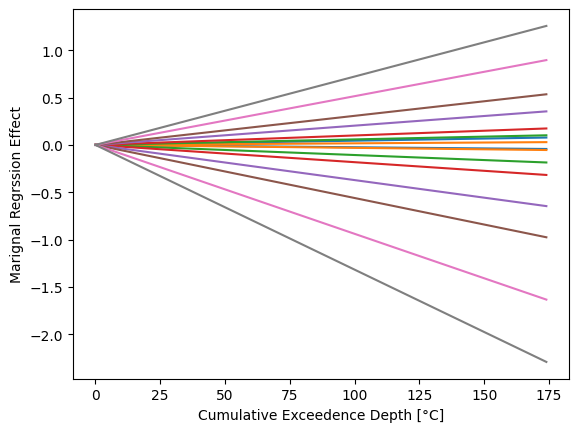

In [7]:
x_EXC = np.arange(0,175,1)

plt.figure()
i_color = 0
for x_T in [12,13,14,15,17.5,20,25,30]:
    plt.plot(x_EXC, country_model.params[1]*x_EXC*x_T + country_model.params[0]*x_EXC, color = sns.color_palette()[i_color])
    plt.plot(x_EXC, country_model.params[3]*x_EXC*x_T + country_model.params[2]*x_EXC, color = sns.color_palette()[i_color])
    i_color += 1
plt.xlabel('Cumulative Exceedence Depth [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

In [8]:
import numpy as np
import matplotlib
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.collections import LineCollection

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    # plt.register_cmap(cmap=newcmap)

    return newcmap

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [9]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['IND', 'USA', 'CHN', 'BRA', 'FRA', 'NGA']
focus_countries_names   = ['India', 'USA', 'China', 'Brazil', 'France', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
focus_colours           = ['lightpink', 'blueviolet', 'gold', 'magenta', 'dodgerblue', 'skyblue'] 
focus_linestyles        = [(0, (1,1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (5,5)), 'solid'] 

In [10]:
# Generate colors from coolwarm colormap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, to_rgb

# Function to blend a color with grey
def dim_color(color, blend_factor=0.4):
    grey = np.array([0.5, 0.5, 0.5])
    return (1 - blend_factor) * np.array(to_rgb(color)) + blend_factor * grey

cmap = plt.get_cmap('coolwarm')
n_colors = cmap.N
colors = [cmap(i) for i in range(n_colors)]

# Dim the colors
dimmed_colors = [dim_color(color) for color in colors]

# Create a new colormap from the dimmed colors
dimmed_cmap = ListedColormap(dimmed_colors, name='dimmed_coolwarm')

In [11]:
orig_cmap    = cm.get_cmap('coolwarm')
# zero change at 12.44°C --> scale colormap such that it is centered around 12.44
dimmed_shifted_cmap = shiftedColorMap(dimmed_cmap, start=0, midpoint = 0.1124, stop = 1)
coolwarm_shifted_cmap = shiftedColorMap(orig_cmap, start=0, midpoint = 0.1124, stop = 1)
sel_colormap = dimmed_shifted_cmap

In [12]:
country_params = country_model.params
global_params  = global_model.params

def compute_marginal_effects_country(exc, tas_baseline): 
    return(country_params[0]*exc + country_params[1]*exc*tas_baseline)

def compute_marginal_effects_glboal(exc): 
    return(global_params[0]*exc)

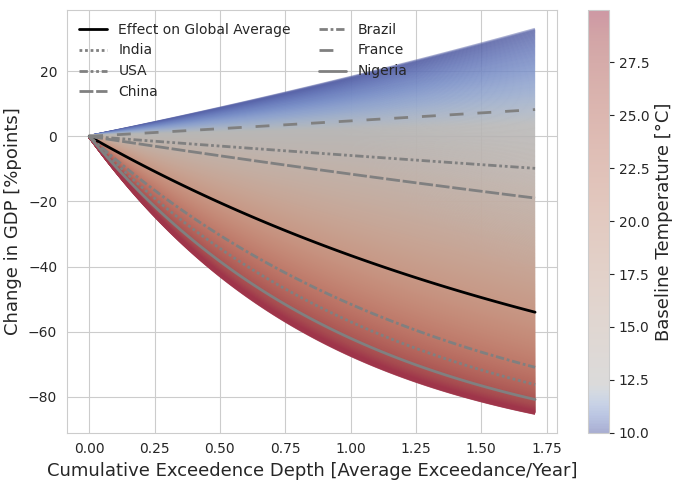

In [13]:
n_steps  = 100
x_exc   = np.linspace(0, 145, n_steps)

with sns.axes_style('whitegrid'):
    x_Ts    = np.arange(10,30,0.025)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    fig, ax = plt.subplots(figsize = (7,5))
    lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .5)

    axcb = fig.colorbar(lc)
    
    y_synth = compute_marginal_effects_glboal(x_exc)
    plt.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Effect on Global Average', color = 'black', linewidth = 2)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        plt.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, color = 'grey', linewidth = 2,  linestyle = focus_linestyles[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = '13')
    ax.legend(loc  = 'upper left', ncols = 2, frameon = False)
    ax.set_xlabel('Cumulative Exceedence Depth [Average Exceedance/Year]', fontsize = '13')
    ax.set_ylabel('Change in GDP [%points]', fontsize = '13')
    plt.tight_layout()

In [46]:
10**1.47719

30.004749131596085

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_75305/143081016.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(sel_colormap)


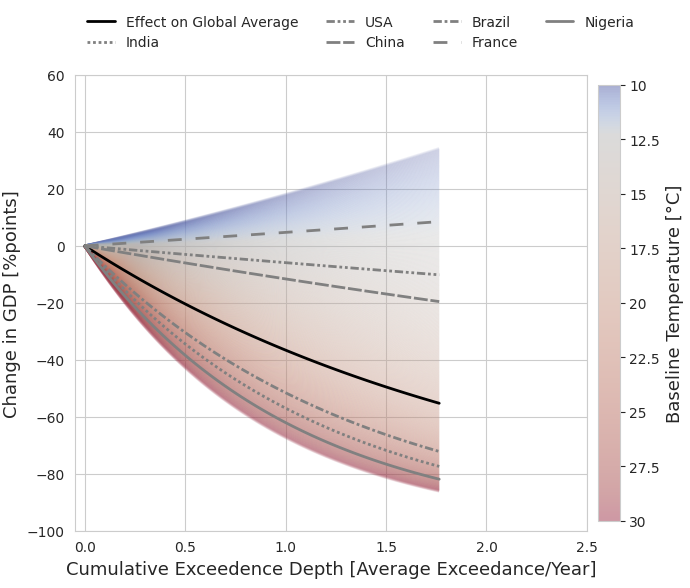

In [14]:
import numpy as np
import matplotlib
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc


# new zealand (NZL) is pretty much zero 
focus_countries         = ['IND', 'USA', 'CHN', 'BRA', 'FRA', 'NGA']
focus_countries_names   = ['India', 'USA', 'China', 'Brazil', 'France', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
focus_colours           = ['lightpink', 'blueviolet', 'gold', 'magenta', 'dodgerblue', 'skyblue'] 
focus_linestyles        = [(0, (1,1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (5,5)), 'solid'] 

country_params = country_model.params
global_params  = global_model.params

def compute_marginal_effects_country(exc, tas_baseline): 
    return(country_params[0]*exc + country_params[1]*exc*tas_baseline)

def compute_marginal_effects_glboal(exc): 
    return(global_params[0]*exc)


n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    fig, ax = plt.subplots(figsize = (7,6))
    lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .1)

    cmap = plt.cm.get_cmap(sel_colormap)
    cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)

    # axcb = fig.colorbar(lc)
    ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    axcb.set_ticks(ticks)
    axcb.set_ticklabels(ticks[::-1])
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    plt.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Effect on Global Average', color = 'black', linewidth = 2)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        plt.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, color = 'grey', linewidth = 2,  linestyle = focus_linestyles[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = '13')
    ax.legend(loc  = 'upper left', ncols = 4, frameon = False, bbox_to_anchor=(0.0, 0.96, 1, 0.2))
    ax.set_xlabel('Cumulative Exceedence Depth [Average Exceedance/Year]', fontsize = '13')
    ax.set_ylabel('Change in GDP [%points]', fontsize = '13')
    plt.ylim(-100, 60)
    plt.xlim(-0.05, 2.5)
    plt.tight_layout()

In [21]:
# Generate colors from coolwarm colormap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, to_rgb

# Function to blend a color with grey
def dim_color(color, blend_factor=0.2):
    grey = np.array([0.5, 0.5, 0.5])
    return (1 - blend_factor) * np.array(to_rgb(color)) + blend_factor * grey

cmap = plt.get_cmap('coolwarm')
n_colors = cmap.N
colors = [cmap(i) for i in range(n_colors)]

# Dim the colors
dimmed_colors = [dim_color(color) for color in colors]

# Create a new colormap from the dimmed colors
dimmed_cmap = ListedColormap(dimmed_colors, name='dimmed_coolwarm')

orig_cmap    = cm.get_cmap('coolwarm')
# zero change at 12.44°C --> scale colormap such that it is centered around 12.44
dimmed_shifted_cmap = shiftedColorMap(dimmed_cmap, start=0, midpoint = 0.1124, stop = 1)
coolwarm_shifted_cmap = shiftedColorMap(orig_cmap, start=0, midpoint = 0.1124, stop = 1)
sel_colormap = coolwarm_shifted_cmap

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_75305/477066843.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(sel_colormap)


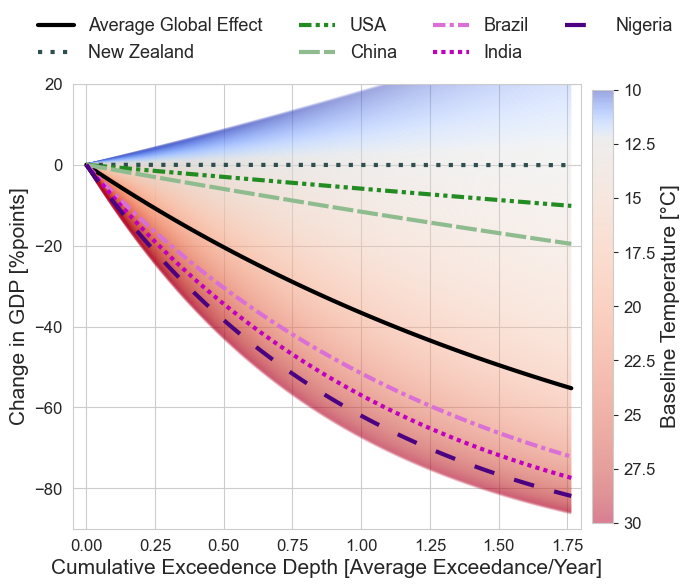

In [23]:
import numpy as np
import matplotlib
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc


# new zealand (NZL) is pretty much zero 
focus_countries         = ['NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = [sns.color_palette("tab10")[i] for i in [0,9,1,2,4,7]]
focus_colours           = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 
                           (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                           (1.0, 0.4980392156862745, 0.054901960784313725), 
                           (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
                           '#7f3f98',
                           '#ffbf00'
                           ]
# focus_colours = [(0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
#                  '#089099', 
#                  '#045275', 
#                  'maroon', 
#                  '#008080', 
#                  '#ffbf00' ]


focus_colours = ['dodgerblue',
                 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                 'darkgoldenrod',
                 'maroon', 
                 '#008080', 
                 'gold' ]


# Define the colors
# colors = ['#ff7f0e', '#ffbf00', '#2ca02c']  # Orange, Yellow, Green
# colors = ['#ff69b4', '#8a2be2', '#1f77b4', '#20b2aa', '#2ca02c']
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)

focus_colours = custom_cmap(np.linspace(0,1,6))


# focus_colours = ['darkslategrey',
#                 'forestgreen',
#                 'darkseagreen',
#                 'm', 
#                 (0.4585928489042676, 0.16147635524798154, 0.5094194540561322, 1.0),
#                 'indigo'
#                 ] 


focus_linestyles        = [  (0,(1, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params

def compute_marginal_effects_country(exc, tas_baseline): 
    return(country_params[0]*exc + country_params[1]*exc*tas_baseline)

def compute_marginal_effects_glboal(exc): 
    return(global_params[0]*exc)


n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    fig, ax = plt.subplots(figsize = (7,6))
    lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    cmap = plt.cm.get_cmap(sel_colormap)
    cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)

    # axcb = fig.colorbar(lc)
    ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    axcb.set_ticks(ticks)
    axcb.set_ticklabels(ticks[::-1], fontsize = 12)
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Average Global Effect', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = '15')
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
    ax.set_xlabel('Cumulative Exceedence Depth [Average Exceedance/Year]', fontsize = 15)
    ax.set_ylabel('Change in GDP [%points]', fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(-90,20)
    plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_34544/2712529123.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r_shiftedv0')


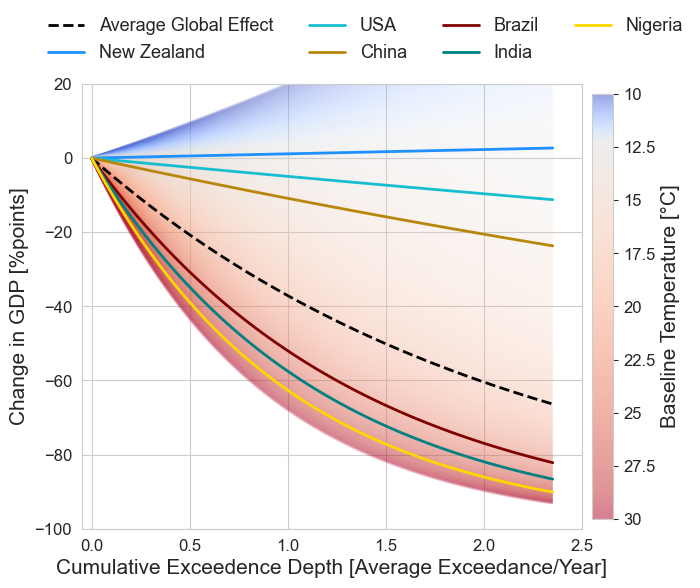

In [242]:
import numpy as np
import matplotlib
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc


# new zealand (NZL) is pretty much zero 
focus_countries         = ['NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = [sns.color_palette("tab10")[i] for i in [0,9,1,2,4,7]]
focus_colours           = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 
                           (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                           (1.0, 0.4980392156862745, 0.054901960784313725), 
                           (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
                           '#7f3f98',
                           '#ffbf00'
                           ]
# focus_colours = [(0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
#                  '#089099', 
#                  '#045275', 
#                  'maroon', 
#                  '#008080', 
#                  '#ffbf00' ]
'#045275'

focus_colours = ['dodgerblue',
                 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                 'darkgoldenrod',
                 'maroon', 
                 '#008080', 
                 'gold' ]
# focus_linestyles        = [(0,(1, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params

def compute_marginal_effects_country(exc, tas_baseline): 
    return(country_params[0]*exc + country_params[1]*exc*tas_baseline)

def compute_marginal_effects_glboal(exc): 
    return(global_params[0]*exc)


n_steps  = 100
x_exc   = np.linspace(0, 200, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    fig, ax = plt.subplots(figsize = (7,6))
    lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap='RdBu_r_shiftedv0', lw=2, alpha = .1)

    cmap = plt.cm.get_cmap('RdBu_r_shiftedv0')
    cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    'RdBu_r_shiftedv0_reversed', cmap(np.linspace(1, 0, cmap.N)))
    
    lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)

    # axcb = fig.colorbar(lc)
    ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    axcb.set_ticks(ticks)
    axcb.set_ticklabels(ticks[::-1], fontsize = 12)
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Average Global Effect', color = 'black', linewidth = 2, linestyle = '--')
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, linewidth = 2,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = '15')
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
    ax.set_xlabel('Cumulative Exceedence Depth [Average Exceedance/Year]', fontsize = 15)
    ax.set_ylabel('Change in GDP [%points]', fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(-100,20)
    plt.xlim(-0.05, 2.5)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

### Temperature vs. Impact Reversibility

In [ ]:
# open gmt data: 


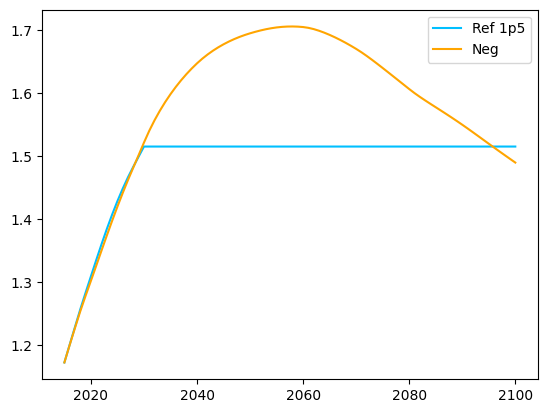

In [112]:
# take Ref1p5 and Neg as examples: 
scenarios = ['Ref1p5', 'Neg']
# scenarios = ['ssp119', 'SP', 'GS', 'ssp534-over', 'CurPol']

list_gmt_mean = []
for i_scen in range(len(scenarios)):
    scenario = scenarios[i_scen]
    gmt_mean = pd.read_csv(Path.joinpath(cset.path_FAIR, f'scen_{scenario}.csv'), index_col = 0).mean(axis = 1).loc[slice(2015,2100)].values
    list_gmt_mean.append(gmt_mean)

plt.figure()
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5')
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

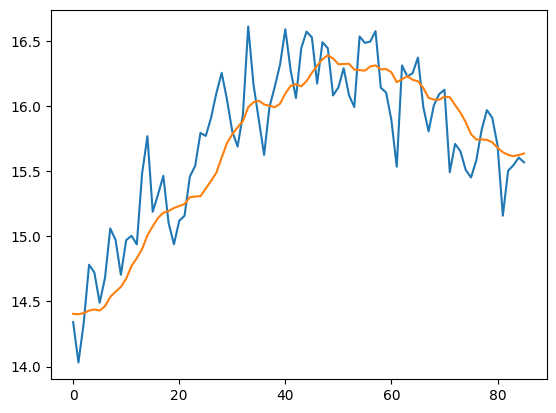

In [113]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=False, min_periods=5).mean().to_numpy()[:, 0]

n_scenarios = 10
scenarios   = cset.scenarios
gmt_smooth  = np.zeros((n_scenarios, 86, 100))
gmt_full    = np.zeros((n_scenarios, 86, 100))
for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    gmt_realisations_tmp     = xr.load_dataset(Path.joinpath(cset.path_MESMER_fldmean, f'{scenario}_fldmean.nc'))['tas'].values[:, :].T
    gmt_realisations_smooth  = np.array([rollavg_pandas(gmt_realisations_tmp[:, i], 10) for i in range(100)]).T
    gmt_smooth[i_scen, :, :] = gmt_realisations_smooth[-86:, :]
    gmt_full[i_scen, :, :]   = gmt_realisations_tmp[-86:, :]
gmt_smooth = np.moveaxis(gmt_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)
gmt_full   = np.moveaxis(gmt_full, [0,1,2], [0,2,1]).reshape(-1, 86)
plt.figure()
plt.plot(gmt_full[705,:])
plt.plot(gmt_smooth[705,:])
plt.show()

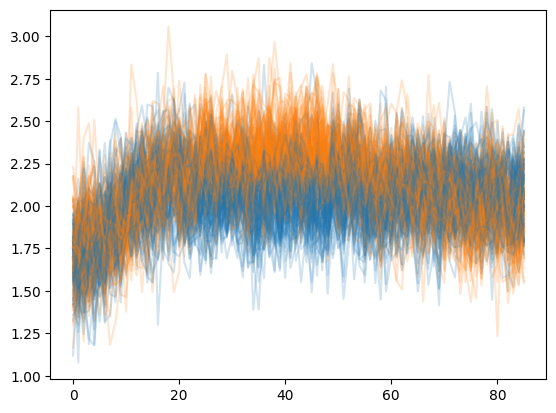

In [114]:
glmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
ref_values = []
for i_scen in range(cset.n_scenarios): 
    scenario = cset.scenarios[i_scen]
    glmt_tmp = xr.load_dataset(Path.joinpath(cset.path_MESMER_fldmean, f"{scenario}_fldmean.nc"))['tas'].values
    ref_values.append(glmt_tmp[:, :50].mean())
    glmt[i_scen*100:(i_scen+1)*100, :] = glmt_tmp[:, -86:]
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
glmt    = glmt - np.mean(ref_values)
columns = np.array(columns).flatten()

plt.figure()
for i in range(100):
    gmt_ref     = glmt[500:600,:].mean(axis = 0)  + (gmt_full[500+i,:] - gmt_smooth[500+i,:])
    gmt_neg     = glmt[200:300,:].mean(axis = 0)  + (gmt_full[200+i,:] - gmt_smooth[200+i,:])
    plt.plot(gmt_ref, color = 'C0', alpha = .2)
    plt.plot(gmt_neg, color = 'C1', alpha = .2)
plt.show()

In [115]:
country_params = country_model.params
global_params  = global_model.params

def compute_full_effects_country(glmt, tas_baseline, glmt_eoc): 
    glmt_exc = (glmt[glmt>thrshld]-thrshld).sum()
    glmt_uxc = -(glmt[glmt<thrshld]-thrshld).sum()
    # impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+glmt_eoc**2*country_params[8]
    impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]
    return(impact)

# def compute_full_effects_country(glmt, tas_baseline): 
#     glmt_exc = (glmt[glmt>thrshld]-thrshld).sum()
#     glmt_uxc = -(glmt[glmt<thrshld]-thrshld).sum()
#     glmt_max = np.sort(glmt)[-5:].mean()
#     impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]
#     return(impact)

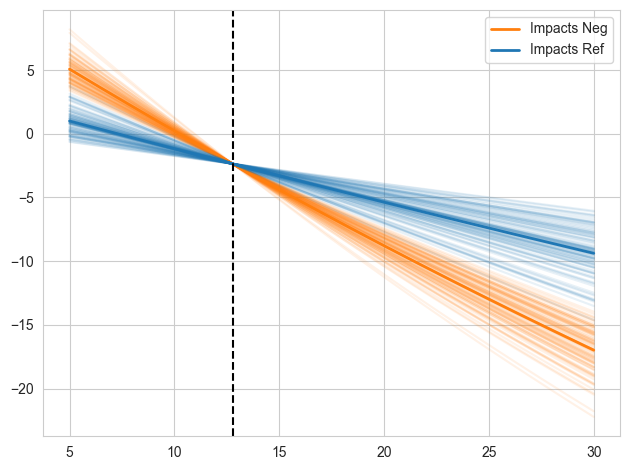

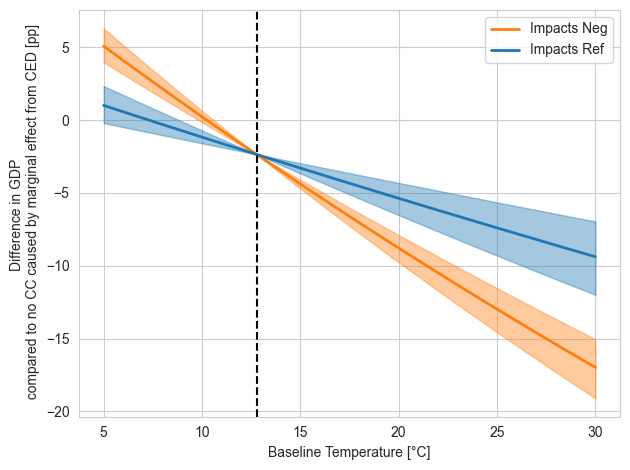

In [116]:
impact_matrix_neg = []
impact_matrix_ref = []

x_Ts        = np.arange(5,30.05,0.05)

glmt_plus = 0
glmt_eoc  = 1.97+glmt_plus

for i in range(100): 
    # gmt_ref     = glmt[500:600,:].mean(axis = 0)  + (gmt_full[500+i,:] - gmt_smooth[500+i,:])
    glmt_ref     = glmt[500:600,:].mean(axis = 0)  + (gmt_full[500+i,:] - gmt_smooth[500+i,:])+glmt_plus
    glmt_neg     = glmt[200:300,:].mean(axis = 0)  + (gmt_full[200+i,:] - gmt_smooth[200+i,:])+glmt_plus

    impact_matrix_neg.append(-(1-np.exp(compute_full_effects_country(glmt_neg, x_Ts, glmt_eoc)))*100)
    impact_matrix_ref.append(-(1-np.exp(compute_full_effects_country(glmt_ref, x_Ts, glmt_eoc)))*100)

impact_matrix_neg = np.array(impact_matrix_neg)
impact_matrix_ref = np.array(impact_matrix_ref)

with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(x_Ts, impact_matrix_neg.T, alpha = .1, color = 'C1')
    plt.plot(x_Ts, np.mean(impact_matrix_neg.T, axis = 1), color = 'C1', linewidth = 2, label = 'Impacts Neg')
    plt.plot(x_Ts, impact_matrix_ref.T, alpha = .1, color = 'C0')
    plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = 'C0', linewidth = 2, label = 'Impacts Ref')
    plt.axvline(12.8, color = 'black', linestyle = '--')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
with sns.axes_style('whitegrid'):
    plt.figure()
    # plt.plot(x_Ts, impact_matrix_neg.T, alpha = .1, color = 'C0')
    plt.fill_between(x_Ts, np.quantile(impact_matrix_neg.T, 0.1, axis = 1), np.quantile(impact_matrix_neg.T, 0.9, axis = 1), color = 'C1', alpha = .4)
    plt.plot(x_Ts, np.mean(impact_matrix_neg.T, axis = 1), color = 'C1', linewidth = 2, label = 'Impacts Neg')
    plt.fill_between(x_Ts, np.quantile(impact_matrix_ref.T, 0.1, axis = 1), np.quantile(impact_matrix_ref.T, 0.9, axis = 1), color = 'C0', alpha = .4)
    plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = 'C0', linewidth = 2, label = 'Impacts Ref')
    plt.axvline(12.8, color = 'black', linestyle = '--')
    plt.xlabel('Baseline Temperature [°C]')
    plt.ylabel('Difference in GDP \n compared to no CC caused by marginal effect from CED [pp]')
    plt.legend()
    plt.tight_layout()
    plt.show()

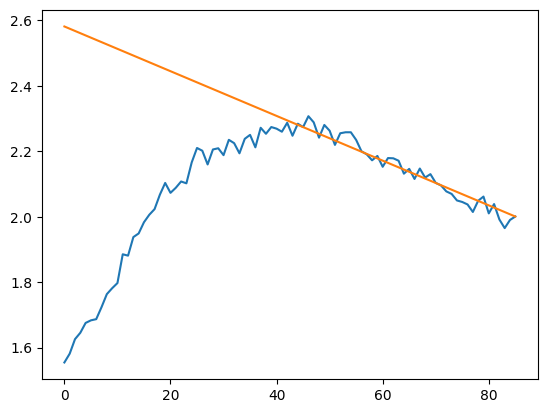

In [117]:
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [glmt[200:300,:].mean(axis = 0)[45], glmt[200:300,:].mean(axis = 0)[-1]], 1)
y_lin_og  = p[0]*x + p[1]
plt.figure()
plt.plot(glmt[200:300,:].mean(axis = 0))
plt.plot(y_lin_og)
plt.show()
# print(glmt_neg_exc, glmt_neg_uxc)

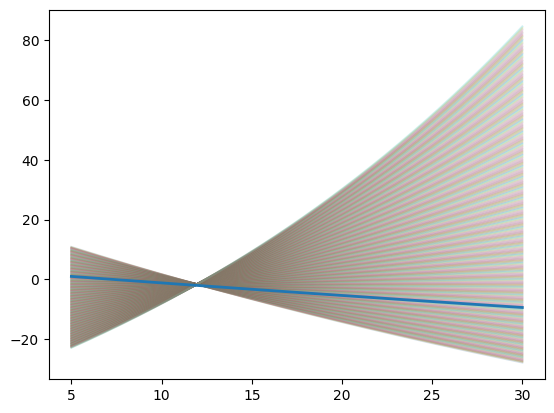

In [118]:
# construct linear function that does through 2060 - max value glmt and 2100 - some eoc value 
# test for different eoc values and construct mean trajectory 

impact_matrix_neg_adj    = []
for x_eoc in np.arange(2.5,-1,-0.01):
    impact_matrix_neg_adj_tmp = []
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    
    for i in range(100):
        gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()+glmt_plus
        gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
        gmt_neg_adj      += (gmt_full[200+i,:] - gmt_smooth[200+i,:])

        impact_matrix_neg_adj_tmp.append(-(1-np.exp(compute_full_effects_country(gmt_neg_adj, x_Ts, x_eoc)))*100)

    impact_matrix_neg_adj.append(np.mean(np.array(impact_matrix_neg_adj_tmp), axis = 0))

impact_matrix_neg_adj = np.array(impact_matrix_neg_adj)


plt.figure()
plt.plot(x_Ts, impact_matrix_neg_adj.T, alpha = .2)
plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = 'C0', linewidth = 2, label = 'Impacts Ref')
plt.show()

2.5
2.0
1.5
1.0
0.5


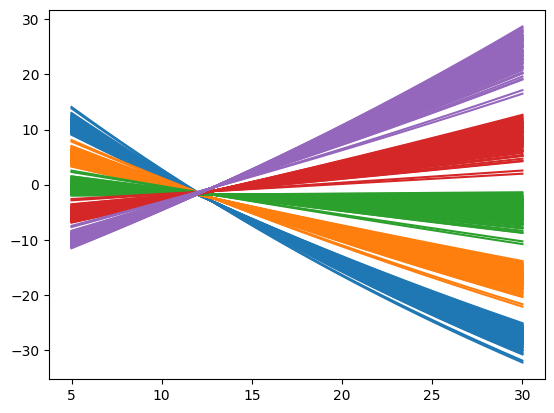

In [119]:
plt.figure()
j = 0
for x_eoc in np.arange(2.5,0,-0.5):
    print(x_eoc)
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    for i in range(100):
        gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()+glmt_plus
        gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
        gmt_neg_adj      += (gmt_full[200+i,:] - gmt_smooth[200+i,:])
        glmt_neg_adj_exc = (gmt_neg_adj[gmt_neg_adj>thrshld]-thrshld).sum()
        glmt_neg_adj_uxc = -(gmt_neg_adj[gmt_neg_adj<thrshld]-thrshld).sum()
        # impact = -(1-np.exp(glmt_neg_adj_exc*country_model.params[0]+glmt_neg_adj_exc*x_Ts*country_model.params[1]+glmt_neg_adj_uxc*country_model.params[2]+glmt_neg_adj_uxc*x_Ts*country_model.params[3]+x_eoc*country_model.params[6]+x_eoc**2*country_model.params[7]+glmt_neg_adj_exc**2*country_model.params[8]))*100
        impact = -(1-np.exp(compute_full_effects_country(gmt_neg_adj, x_Ts, x_eoc)))*100
        plt.plot(x_Ts, impact, color = f'C{j}')
    j += 1
# plt.plot(x_Ts, np.mean(impact_matrix_ref.T, axis = 1), color = f'black')
plt.show()

In [120]:
idx_min = np.abs(impact_matrix_neg_adj-np.mean(impact_matrix_ref.T, axis = 1)).argmin(axis = 0)

In [121]:
gmt_trajectories_equal = []

for i in range(len(x_Ts)): 
    idx    = idx_min[i]
    x_eoc = np.arange(2.5,-1,-0.01)[idx]
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()+glmt_plus
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

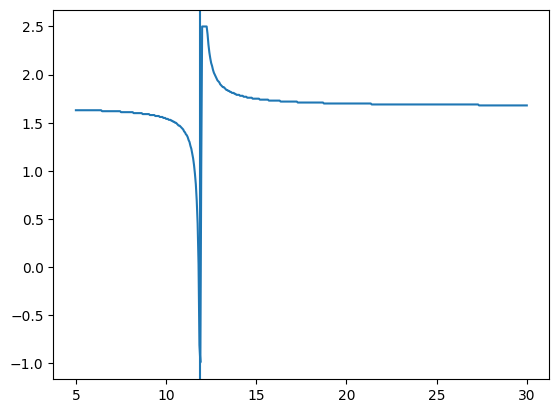

In [122]:
plt.figure()
plt.plot(x_Ts, np.arange(2.5,-1,-0.01)[idx_min])
plt.axvline(11.9)
plt.show()

In [123]:
gmt_trajectories_equal = []

for i in range(len(x_Ts)): 
    idx    = idx_min[i]
    x_eoc = np.arange(2.5,-1,-0.01)[idx]
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [ 2.27, x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = glmt[200:300,:].mean(axis = 0).copy()+glmt_plus
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

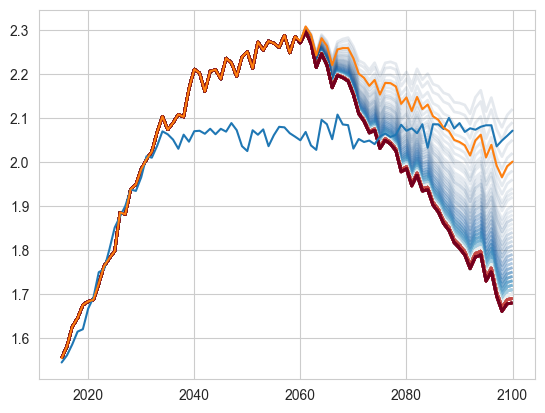

In [124]:
with sns.axes_style('whitegrid'):
    plt.figure()
    lc  = multiline(np.array([np.linspace(2015,2100,86) for i in range(501-150)]),  gmt_trajectories_equal[150:, :], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
    # plt.plot(gmt_trajectories_equal.T, color = 'C1', alpha = .1)
    # plt.plot(gmt_trajectories_equal.T[:, ::50])
    plt.plot(np.linspace(2015,2100,86), glmt[500:600,:].mean(axis = 0)+glmt_plus)
    plt.plot(np.linspace(2015,2100,86), glmt[200:300,:].mean(axis = 0)+glmt_plus)
    plt.show()

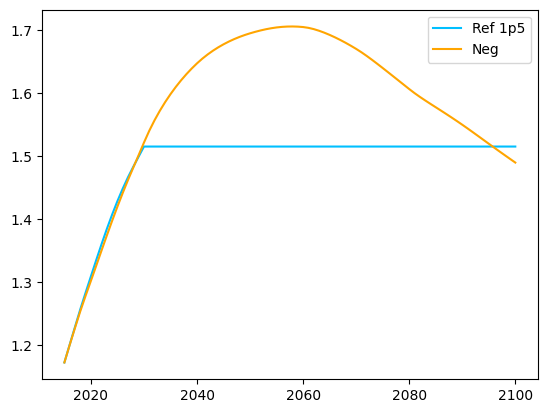

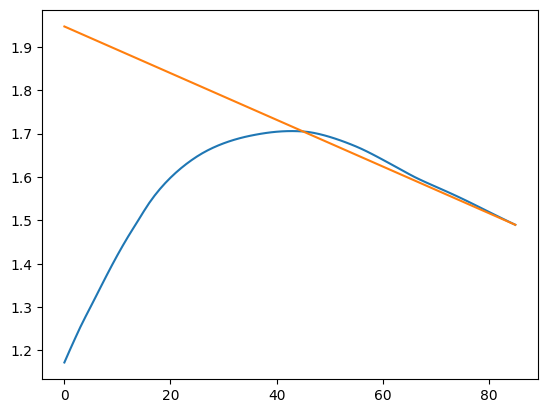

In [125]:
# take Ref1p5 and Neg as examples: 
scenarios = ['Ref1p5', 'Neg']
# scenarios = ['ssp119', 'SP', 'GS', 'ssp534-over', 'CurPol']

list_gmt_mean = []
for i_scen in range(len(scenarios)):
    scenario = scenarios[i_scen]
    gmt_mean = pd.read_csv(Path.joinpath(cset.path_FAIR, f'scen_{scenario}.csv'), index_col = 0).mean(axis = 1).loc[slice(2015,2100)].values
    list_gmt_mean.append(gmt_mean)


# translating EOC temperatures back:  
plt.figure()
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5')
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [list_gmt_mean[1][45], list_gmt_mean[1][-1]], 1)
y_lin_og  = p[0]*x + p[1]
plt.figure()
plt.plot(list_gmt_mean[1])
plt.plot(y_lin_og)
plt.show()

In [126]:
gmt_trajectories_equal = []

for i in range(len(x_Ts)): 
    idx    = idx_min[i]
    x_eoc = np.arange(2.5,-1,-0.01)[idx]-0.565
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [ 1.705, x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = list_gmt_mean[1]+glmt_plus
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

In [127]:
focus_countries         = ['NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = [sns.color_palette("tab10")[i] for i in [0,9,1,2,4,7]]
# focus_colours           = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 
#                            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
#                            (1.0, 0.4980392156862745, 0.054901960784313725), 
#                            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#                            '#7f3f98',
#                            '#ffbf00'
#                            ]
# focus_colours = [(0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
#                  '#089099', 
#                  '#045275', 
#                  'maroon', 
#                  '#008080', 
#                  '#ffbf00' ]
'#045275'

focus_colours = ['dodgerblue',
                 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                 'darkgoldenrod',
                 'maroon', 
                 '#008080', 
                 'gold' ]



In [128]:
idx_country = [np.abs(x_Ts-focus_temperatures[i_country]).argmin() for i_country in range(len(focus_countries))]

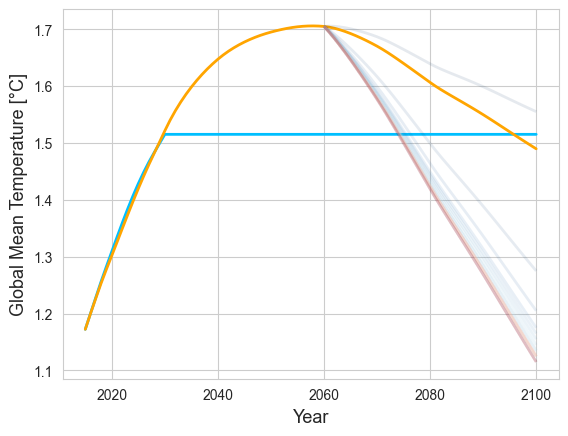

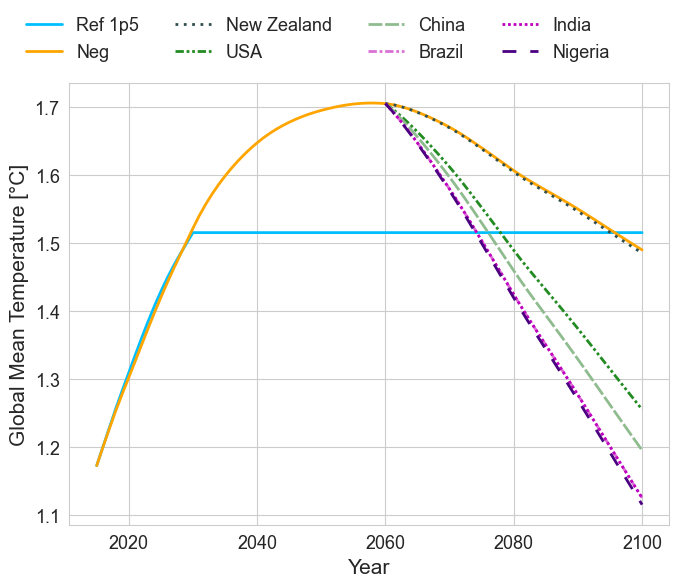

In [141]:
with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5', linewidth = 2)
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg', linewidth = 2)
    
    lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(20)]),  gmt_trajectories_equal[150:, 45:][::18], x_Ts[150:][::18], cmap='RdBu_r', lw=2, alpha =.1)
    # plt.plot(gmt_trajectories_equal.T, color = 'C1', alpha = .1)
    # plt.plot(gmt_trajectories_equal.T[:, ::50])
    # for i_country in range(len(focus_countries)):
    #     plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 2, linestyle = '-')

    plt.xlabel('Year', fontsize = 13)
    plt.ylabel('Global Mean Temperature [°C]', fontsize = 13)
    plt.show()

with sns.axes_style('whitegrid'):
    plt.figure(figsize = (7,6))
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5', linewidth = 2)
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg', linewidth = 2)
    
    # lc  = multiline(np.array([np.linspace(2015,2100,86) for i in range(501-150)]),  gmt_trajectories_equal[150:, :], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
    # plt.plot(gmt_trajectories_equal.T, color = 'C1', alpha = .1)
    # plt.plot(gmt_trajectories_equal.T[:, ::50])
    for i_country in range(len(focus_countries)):
        plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 2, linestyle = focus_linestyles[i_country])

    plt.tick_params(labelsize = 13)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Global Mean Temperature [°C]', fontsize = 15)
    plt.legend(ncols = 4, loc  = 'center left', frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
    plt.tight_layout()
    plt.show()

In [ ]:
x_GEOC    = np.arange(2.5,-1,-0.01)[idx_min]-0.6
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [1.705, x_eoc], 1)
y_lin     = p[0]*x + p[1]

for i in range(100):
    gmt_neg_adj      = list_gmt_mean[1][45]+glmt_plus
    gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]


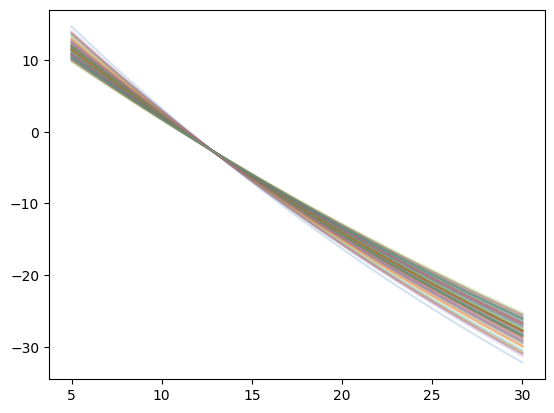

In [48]:
plt.figure()
plt.plot(x_Ts, impact_matrix_ref.T, alpha = .2)
plt.show()

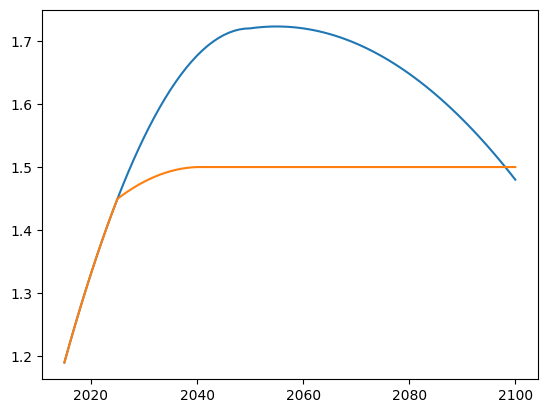

In [263]:
x_eoc = 1.5
x_os  = 1.72
x_soc = 1.2

x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)

# overshoot pathway: 2015 - 1.1, 2050 - 1.75, 2100 - 1.5
p1    = np.polyfit([2015, 2050, 2085], 
                    [x_soc-0.01, x_os, x_soc-0.01],
                    deg = 2)

p2    = np.polyfit([2010, 2050, 2100], 
                    [x_eoc-0.02, x_os ,x_eoc-0.02],
                    deg = 2)

gmt_3        = p1[0]*x**2+p1[1]*x+p1[2]
# gmt_3[36:40] = gmt_3[35]
gmt_3[36:]   = p2[0]*x[36:]**2+p2[1]*x[36:]+p2[2]

# ref pathway: 
p1    = np.polyfit([2025, 2030, 2040], 
                    [gmt_3[10], gmt_3[10]+0.027, x_eoc],
                    deg = 2)

gmt_2        = gmt_3.copy()
gmt_2[10:26] = p1[0]*x[10:26]**2+p1[1]*x[10:26]+p1[2]
gmt_2[26:]   = gmt_2[25]


plt.figure()
# plt.plot(x, gmt_2)
plt.plot(x, gmt_3)
plt.plot(x, gmt_2)
plt.show()

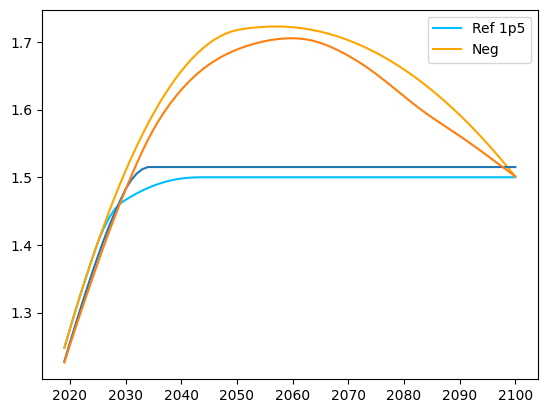

In [264]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=False, min_periods=5).mean().to_numpy()[:, 0]


gmt_2_smooth = rollavg_pandas(gmt_2,5)
gmt_3_smooth = rollavg_pandas(gmt_3,5)

plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.plot(x, gmt_ref_smooth)
plt.plot(x, gmt_neg_smooth)
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

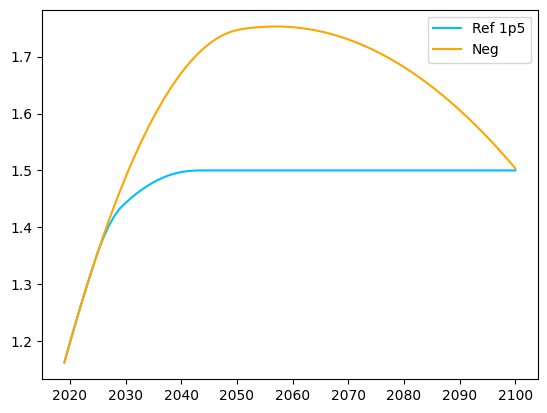

In [247]:
plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

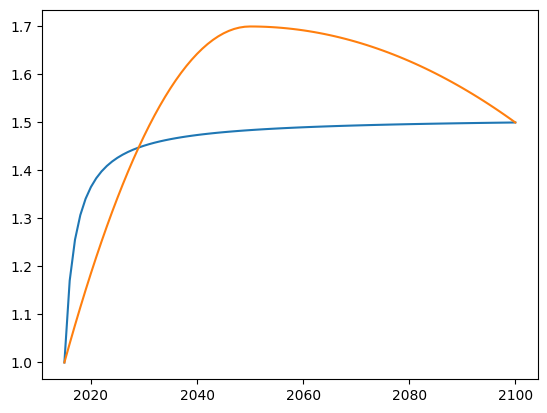

In [205]:
# constructing pathways 

# trajectory without peak and decline: 
x_eoc = 1.5
x_os  = 1.75
scale = 0.5

### ref 
x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)
p     = np.polyfit(x_gen*scale/(1+x_gen*scale), 
                    [1,x_eoc],
                    deg = 1)
gmt_2 = p[0]*(x-2015)*scale/(scale*(x-2015)+1)+p[1]

### overshoot
p1    = np.polyfit([2015,2050,2085], 
                    [1,x_os,1],
                    deg = 2)
p2    = np.polyfit([2000,2050,2100], 
                    [x_eoc,x_os,x_eoc],
                    deg = 2)

gmt_3      = p1[0]*x**2+p1[1]*x+p1[2]
gmt_3[35:] = p2[0]*x[35:]**2+p2[1]*x[35:]+p2[2]

plt.figure()
plt.plot(x, gmt_2)
plt.plot(x, gmt_3)
plt.show()

In [177]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=True, min_periods=1).mean().to_numpy()[:, 0]

n_scenarios = 10
scenarios   = cset.scenarios
gmt_smooth  = np.zeros((n_scenarios, 86, 100))
for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    glmt_tmp = xr.load_dataset(Path.joinpath(cset.path_MESMER_fldmean, f"{scenario}_fldmean.nc"))['tas'].values
    glmt_ref = glmt_tmp[:, :50].mean(axis = 1)
    gmt_realisations_tmp     = (glmt_tmp[:, :].T - glmt_ref)
    gmt_realisations_smooth  = np.array([rollavg_pandas(gmt_realisations_tmp[:, i], 15) for i in range(100)]).T
    gmt_smooth[i_scen, :, :] = gmt_realisations_smooth[-86:, :]
gmt_smooth = np.moveaxis(gmt_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)

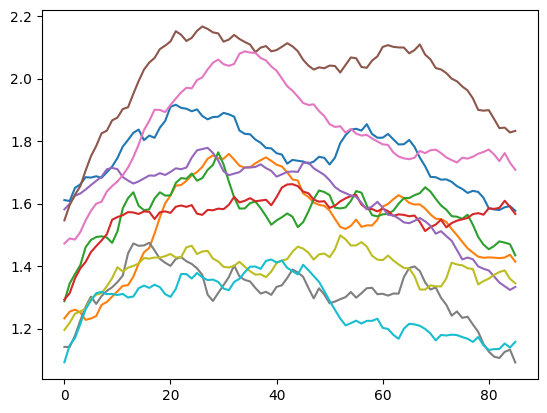

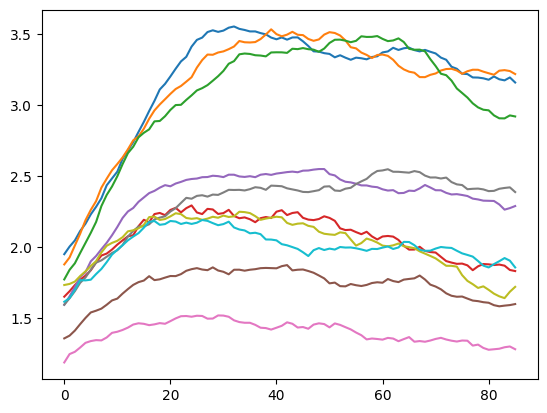

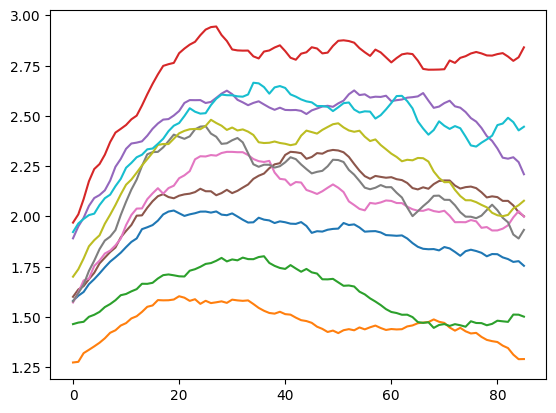

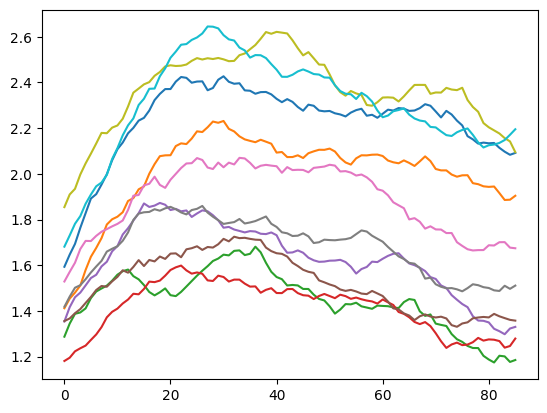

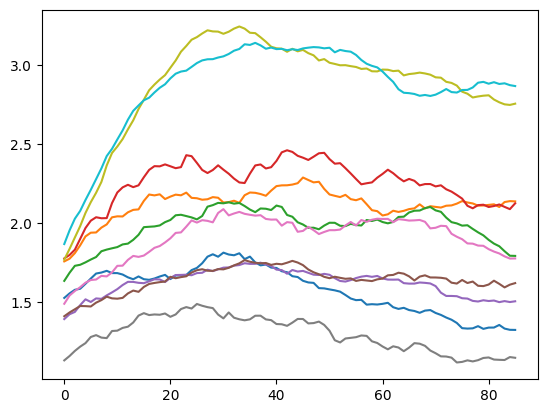

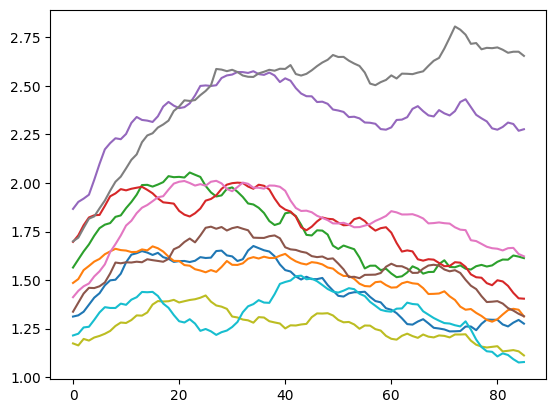

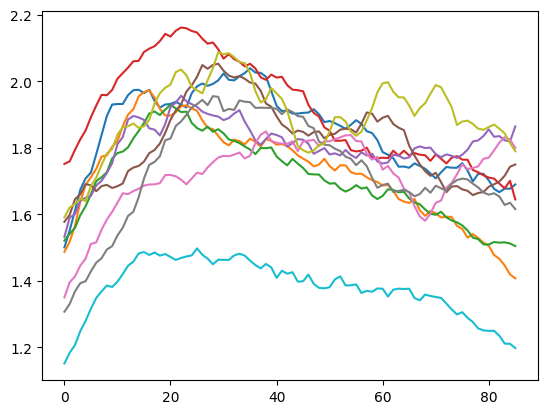

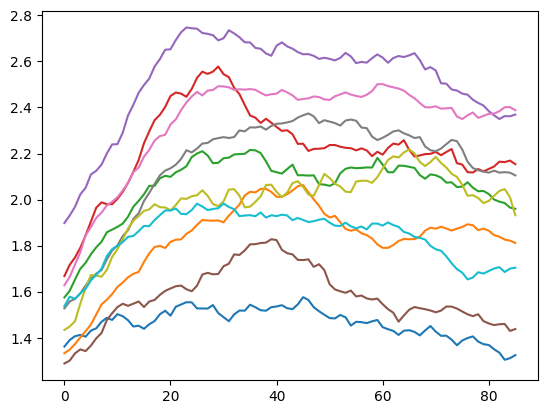

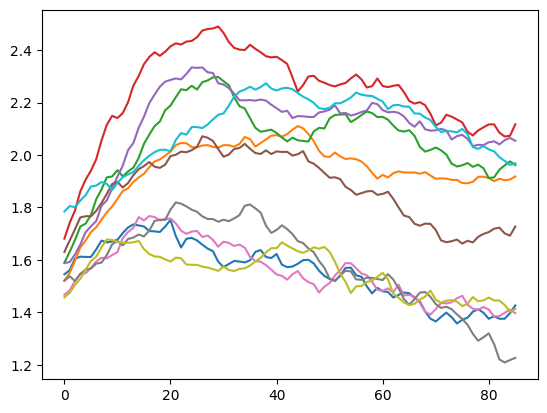

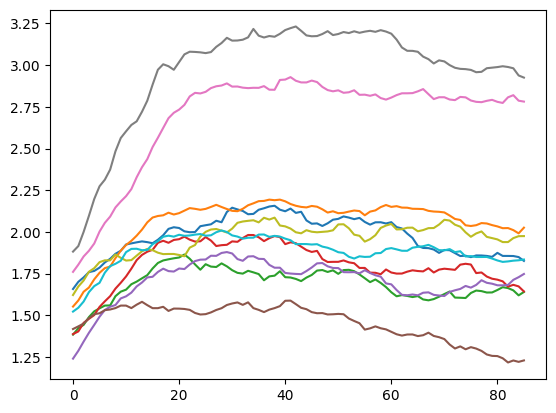

In [180]:
for i in range(10):
    plt.figure()
    plt.plot(gmt_smooth[i*10:(i+1)*10,:].T)
    plt.show()

In [ ]:
# trajectory without peak and decline: 
x_eoc = 1.8

### ref 
x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)
p     = np.polyfit(x_gen*0.08/(1+x_gen*0.08), 
                    [1,1.8],
                    deg = 1)
gmt_2 = p[0]*(x-2015)*0.075/(0.075*(x-2015)+1)+p[1]

### overshoot
p1    = np.polyfit([2015,2050,2085], 
                    [1,2.0,1],
                    deg = 2)
p2    = np.polyfit([2000,2050,2100], 
                    [1.8,2.0,1.8],
                    deg = 2)

gmt_3      = p1[0]*x**2+p1[1]*x+p1[2]
gmt_3[35:] = p2[0]*x[35:]**2+p2[1]*x[35:]+p2[2]

# compute impact for different temperatures: 
gmt_2_constructed = gmt_2+gmt_tmp[102,:]-gmt_smooth[102,:]
gmt_3_constructed = gmt_3+gmt_tmp[102,:]-gmt_smooth[102,:]

gmt_2_exc = (gmt_2_constructed[gmt_2_constructed>1.2]-1.2).sum()
gmt_2_uxc = -(gmt_2_constructed[gmt_2_constructed<1.2]-1.2).sum()
gmt_3_exc = (gmt_3_constructed[gmt_3_constructed>1.2]-1.2).sum()
gmt_3_uxc = -(gmt_3_constructed[gmt_3_constructed<1.2]-1.2).sum()


x_Ts      = np.arange(10,30.05,0.05)
impacts_2 = -(1-np.exp(gmt_2_exc*results_country_params[1]+gmt_2_exc*x_Ts*results_country_params[5]+gmt_2_uxc*results_country_params[2]+gmt_2_uxc*x_Ts*results_country_params[6]+x_eoc*results_country_params[3]))*100
impacts_3 = -(1-np.exp(gmt_3_exc*results_country_params[1]+gmt_3_exc*x_Ts*results_country_params[5]+gmt_3_uxc*results_country_params[2]+gmt_3_uxc*x_Ts*results_country_params[6]+x_eoc*results_country_params[3]))*100